# Newton Raphson Load Flow Function

In [1]:
import numpy as np
def NRPF(busdata, linedata, basemva, accuracy, maxiter):
    j = 1j
    nl = linedata[:, 0].astype(int) - 1
    nr = linedata[:, 1].astype(int) - 1
    R = linedata[:, 2]
    X = linedata[:, 3]
    Bc = j * linedata[:, 4]
    a = linedata[:, 5]
    nbr = len(linedata[:, 0])
    nbus = max(np.max(nl), np.max(nr)) + 1
    Z = R + j * X
    y = 1 / Z
    Ybus = np.zeros((nbus, nbus), dtype=complex)
    for k in range(nbr):
        if a[k] <= 0:
            a[k] = 1
        Ybus[nl[k], nr[k]] -= y[k] / a[k]
        Ybus[nr[k], nl[k]] = Ybus[nl[k], nr[k]]
    for n in range(nbus):
        for k in range(nbr):
            if nl[k] == n:
                Ybus[n, n] += y[k] / (a[k] ** 2) + Bc[k]
            elif nr[k] == n:
                Ybus[n, n] += y[k] + Bc[k]
    ns = 0
    ng = 0
    Vm = np.zeros(nbus)
    delta = np.zeros(nbus)
    Pd = np.zeros(nbus)
    Qd = np.zeros(nbus)
    Pg = np.zeros(nbus)
    Qg = np.zeros(nbus)
    Qmin = np.zeros(nbus)
    Qmax = np.zeros(nbus)
    Qsh = np.zeros(nbus)
    kb = np.zeros(nbus, dtype=int)
    nss = np.zeros(nbus, dtype=int)
    ngs = np.zeros(nbus, dtype=int)
    for k in range(len(busdata)):
        n = int(busdata[k, 0]) - 1
        kb[n] = int(busdata[k, 1])
        Vm[n] = busdata[k, 2]
        delta[n] = busdata[k, 3]
        Pd[n] = busdata[k, 4]
        Qd[n] = busdata[k, 5]
        Pg[n] = busdata[k, 6]
        Qg[n] = busdata[k, 7]
        Qmin[n] = busdata[k, 8]
        Qmax[n] = busdata[k, 9]
        Qsh[n] = busdata[k, 10]
        if Vm[n] <= 0:
            Vm[n] = 1.0
            V = np.ones(nbus, dtype=complex)
        else:
            delta[n] = np.pi / 180 * delta[n]
            V = Vm * (np.cos(delta) + j * np.sin(delta))
            P = (Pg - Pd) / basemva
            Q = (Qg - Qd + Qsh) / basemva
            S = P + j * Q
    for k in range(nbus):
        if kb[k] == 1:
            ns += 1
        if kb[k] == 2:
            ng += 1
        ngs[k] = ng
        nss[k] = ns
    Ym = np.abs(Ybus)
    t = np.angle(Ybus)
    m = 2 * nbus - ng - 2 * ns
    maxerror = 1
    converge = True
    iter = 0
    A = np.zeros((m, m))
    DC = np.zeros(m)
    while maxerror >= accuracy and iter <= maxiter:
        iter += 1
        A.fill(0)
        for n in range(nbus):
            nn = n - nss[n]
            lm = nbus + n - ngs[n] - nss[n] - ns
            J11 = J22 = J33 = J44 = 0

            for i in range(nbr):
                if nl[i] == n or nr[i] == n:
                    l = nr[i] if nl[i] == n else nl[i]
                    J11 += Vm[n] * Vm[l] * Ym[n, l] * np.sin(t[n, l] - delta[n] + delta[l])
                    J33 += Vm[n] * Vm[l] * Ym[n, l] * np.cos(t[n, l] - delta[n] + delta[l])
                    if kb[n] != 1:
                        J22 += Vm[l] * Ym[n, l] * np.cos(t[n, l] - delta[n] + delta[l])
                        J44 += Vm[l] * Ym[n, l] * np.sin(t[n, l] - delta[n] + delta[l])
                    if kb[n] != 1 and kb[l] != 1:
                        lk = nbus + l - ngs[l] - nss[l] - ns
                        ll = l - nss[l]
                        A[nn, ll] = -Vm[n] * Vm[l] * Ym[n, l] * np.sin(t[n, l] - delta[n] + delta[l])
                        if kb[l] == 0:
                            A[nn, lk] = Vm[n] * Ym[n, l] * np.cos(t[n, l] - delta[n] + delta[l])
                        if kb[n] == 0:
                            A[lm, ll] = -Vm[n] * Vm[l] * Ym[n, l] * np.cos(t[n, l] - delta[n] + delta[l])
                        if kb[n] == 0 and kb[l] == 0:
                            A[lm, lk] = -Vm[n] * Ym[n, l] * np.sin(t[n, l] - delta[n] + delta[l])
            Pk = Vm[n] ** 2 * Ym[n, n] * np.cos(t[n, n]) + J33
            Qk = -Vm[n] ** 2 * Ym[n, n] * np.sin(t[n, n]) - J11
            if kb[n] == 1:
                P[n] = Pk
                Q[n] = Qk
            if kb[n] == 2:
                Q[n] = Qk
                if Qmax[n] != 0:
                    Qgc = Q[n] * basemva + Qd[n] - Qsh[n]
                    if 2 < iter <= 7:
                        if Qgc < Qmin[n]:
                            Vm[n] += 0.01
                        elif Qgc > Qmax[n]:
                            Vm[n] -= 0.01
            if kb[n] != 1:
                A[nn, nn] = J11
                DC[nn] = P[n] - Pk
            if kb[n] == 0:
                A[nn, lm] = 2 * Vm[n] * Ym[n, n] * np.cos(t[n, n]) + J22
                A[lm, nn] = J33
                A[lm, lm] = -2 * Vm[n] * Ym[n, n] * np.sin(t[n, n]) - J44
                DC[lm] = Q[n] - Qk
        DX = np.linalg.solve(A, DC)
        for n in range(nbus):
            nn = n - nss[n]
            lm = nbus + n - ngs[n] - nss[n] - ns
            if kb[n] != 1:
                delta[n] += DX[nn]
            if kb[n] == 0:
                Vm[n] += DX[lm]
        maxerror = np.max(np.abs(DC))
        if iter == maxiter and maxerror > accuracy:
            print(f'\nWARNING: Iterative solution did not converge after {iter} iterations.\n')
            converge = False
    tech = 'Power Flow Solution by Newton-Raphson Method' if converge else 'ITERATIVE SOLUTION DID NOT CONVERGE'
    V = Vm * (np.cos(delta) + j * np.sin(delta))
    deltad = np.degrees(delta)
    SLT = 0
    SL = np.zeros(nbr, dtype=complex)
    for n in range(nbus):
        for L in range(nbr):
            if nl[L] == n:
                k = nr[L]
                In = (V[n] - a[L] * V[k]) * y[L] / a[L] ** 2 + Bc[L] / a[L] ** 2 * V[n]
                Ik = (V[k] - V[n] / a[L]) * y[L] + Bc[L] * V[k]
                Snk = V[n] * np.conj(In) * basemva
                Skn = V[k] * np.conj(Ik) * basemva
                SL[L] = Snk + Skn
                SLT += SL[L]
            elif nr[L] == n:
                k = nl[L]
                In = (V[n] - V[k] / a[L]) * y[L] + Bc[L] * V[n]
                Ik = (V[k] - a[L] * V[n]) * y[L] / a[L] ** 2 + Bc[L] / a[L] ** 2 * V[k]
                Snk = V[n] * np.conj(In) * basemva
                Skn = V[k] * np.conj(Ik) * basemva
                SL[L] = Snk + Skn
                SLT += SL[L]
    SLT /= 2
    Loss = np.real(SLT)
    QLoss = np.imag(SLT)
    branchloss = np.real(SL)
    print(tech)
    print(f'Maximum Power Mismatch = {maxerror}')
    print(f'No. of Iterations = {iter}\n')
    header = 'Bus  Voltage  Angle    ------Load------    ---Generation---   Injected\n'
    header += 'No.  Mag.     Degree     MW       Mvar       MW       Mvar       Mvar\n'
    print(header)
    for n in range(nbus):
        print(f'{n+1:5d} {Vm[n]:7.3f} {deltad[n]:8.3f} {Pd[n]:9.3f} {Qd[n]:9.3f} {Pg[n]:9.3f} {Qg[n]:9.3f} {Qsh[n]:8.3f}')
    print(f'Total {sum(Pd):9.3f} {sum(Qd):9.3f} {sum(Pg):9.3f} {sum(Qg):9.3f} {sum(Qsh):9.3f}\n')
    return Vm, delta, P, Q, Loss, QLoss, tech, branchloss

# Busdata and Linedata for IEEE 33-Bus System

In [2]:
basekv = 12.66 #KV
basemva = 100  #MVA
base_impedance = (basekv)**2 / basemva
s = 1 / base_impedance
x = 0.001
      #  Each row in busdata contains:
      #  Bus Number
      #  Bus Code (1=slack bus, 0=load/PQ bus, 2=generator/PV bus)
      #  Initial Voltage magnitude at each bus
      #  Initial Voltage angle (degrees) at each bus
      #  Active power demand at each bus (MW)
      #  Reactive power demand at each bus (Mvar)
      #  Active power generation at each bus (MW)
      #  Reactive power generation at each bus (Mvar)
      #  Generator Qmin
      #  Generator Qmax
      #  Injected Mvar
original_busdata = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 1, 0, 100 * x, 60 * x, 0, 0, 0, 0, 0],
    [3, 0, 1, 0, 90 * x, 40 * x, 0, 0, 0, 0, 0],
    [4, 0, 1, 0, 120 * x, 80 * x, 0, 0, 0, 0, 0],
    [5, 0, 1, 0, 60 * x, 30 * x, 0, 0, 0, 0, 0],
    [6, 0, 1, 0, 60 * x, 20 * x, 0, 0, 0, 0, 0],
    [7, 0, 1, 0, 200 * x, 100 * x, 0, 0, 0, 0, 0],
    [8, 0, 1, 0, 200 * x, 100 * x, 0, 0, 0, 0, 0],
    [9, 0, 1, 0, 60 * x, 20 * x, 0, 0, 0, 0, 0],
    [10, 0, 1, 0, 60 * x, 20 * x, 0, 0, 0, 0, 0],
    [11, 0, 1, 0, 45 * x, 30 * x, 0, 0, 0, 0, 0],
    [12, 0, 1, 0, 60 * x, 35 * x, 0, 0, 0, 0, 0],
    [13, 0, 1, 0, 60 * x, 35 * x, 0, 0, 0, 0, 0],
    [14, 0, 1, 0, 120 * x, 80 * x, 0, 0, 0, 0, 0],
    [15, 0, 1, 0, 60 * x, 10 * x, 0, 0, 0, 0, 0],
    [16, 0, 1, 0, 60 * x, 20 * x, 0, 0, 0, 0, 0],
    [17, 0, 1, 0, 60 * x, 20 * x, 0, 0, 0, 0, 0],
    [18, 0, 1, 0, 90 * x, 40 * x, 0, 0, 0, 0, 0],
    [19, 0, 1, 0, 90 * x, 40 * x, 0, 0, 0, 0, 0],
    [20, 0, 1, 0, 90 * x, 40 * x, 0, 0, 0, 0, 0],
    [21, 0, 1, 0, 90 * x, 40 * x, 0, 0, 0, 0, 0],
    [22, 0, 1, 0, 90 * x, 40 * x, 0, 0, 0, 0, 0],
    [23, 0, 1, 0, 90 * x, 50 * x, 0, 0, 0, 0, 0],
    [24, 0, 1, 0, 420 * x, 200 * x, 0, 0, 0, 0, 0],
    [25, 0, 1, 0, 420 * x, 200 * x, 0, 0, 0, 0, 0],
    [26, 0, 1, 0, 60 * x, 25 * x, 0, 0, 0, 0, 0],
    [27, 0, 1, 0, 60 * x, 25 * x, 0, 0, 0, 0, 0],
    [28, 0, 1, 0, 60 * x, 20 * x, 0, 0, 0, 0, 0],
    [29, 0, 1, 0, 120 * x, 70 * x, 0, 0, 0, 0, 0],
    [30, 0, 1, 0, 200 * x, 600 * x, 0, 0, 0, 0, 0],
    [31, 0, 1, 0, 150 * x, 70 * x, 0, 0, 0, 0, 0],
    [32, 0, 1, 0, 210 * x, 100 * x, 0, 0, 0, 0, 0],
    [33, 0, 1, 0, 60 * x, 40 * x, 0, 0, 0, 0, 0]
])
  #  Each row in linedata contains:
  #  nl: From bus number
  #  nr: To bus number
  #  R: Resistance
  #  X: Reactance
  #  Bc: Shunt admittance
  #  a: Transformer tap ratio
linedata = np.array([
    [1, 2, 0.0922 * s, 0.047 * s, 0, 1],
    [2, 3, 0.493 * s, 0.2511 * s, 0, 1],
    [3, 4, 0.366 * s, 0.1864 * s, 0, 1],
    [4, 5, 0.3811 * s, 0.1941 * s, 0, 1],
    [5, 6, 0.819 * s, 0.707 * s, 0, 1],
    [6, 7, 0.1872 * s, 0.6188 * s, 0, 1],
    [7, 8, 0.7114 * s, 0.2351 * s, 0, 1],
    [8, 9, 1.03 * s, 0.74 * s, 0, 1],
    [9, 10, 1.044 * s, 0.74 * s, 0, 1],
    [10, 11, 0.1966 * s, 0.065 * s, 0, 1],
    [11, 12, 0.3744 * s, 0.1238 * s, 0, 1],
    [12, 13, 1.468 * s, 1.155 * s, 0, 1],
    [13, 14, 0.5416 * s, 0.7129 * s, 0, 1],
    [14, 15, 0.591 * s, 0.526 * s, 0, 1],
    [15, 16, 0.7463 * s, 0.545 * s, 0, 1],
    [16, 17, 1.289 * s, 1.721 * s, 0, 1],
    [17, 18, 0.732 * s, 0.574 * s, 0, 1],
    [2, 19, 0.164 * s, 0.1565 * s, 0, 1],
    [19, 20, 1.5042 * s, 1.3554 * s, 0, 1],
    [20, 21, 0.4095 * s, 0.4784 * s, 0, 1],
    [21, 22, 0.7089 * s, 0.9373 * s, 0, 1],
    [3, 23, 0.4512 * s, 0.3083 * s, 0, 1],
    [23, 24, 0.898 * s, 0.7091 * s, 0, 1],
    [24, 25, 0.896 * s, 0.7011 * s, 0, 1],
    [6, 26, 0.203 * s, 0.1034 * s, 0, 1],
    [26, 27, 0.2842 * s, 0.1447 * s, 0, 1],
    [27, 28, 1.059 * s, 0.9337 * s, 0, 1],
    [28, 29, 0.8042 * s, 0.7006 * s, 0, 1],
    [29, 30, 0.5075 * s, 0.2585 * s, 0, 1],
    [30, 31, 0.9744 * s, 0.963 * s, 0, 1],
    [31, 32, 0.3105 * s, 0.3619 * s, 0, 1],
    [32, 33, 0.341 * s, 0.5302 * s, 0, 1]
])

# Load Flow for Peak Hour

In [3]:
accuracy = 0.001
maxiter = 1000
# Load levels for 24 hour time resolution
loadlevel = np.array([65, 60, 56, 57, 58, 58.5, 59, 62, 67, 69.5, 72, 79, 88, 93, 98, 100, 97, 93, 88, 85.5, 82, 73, 62, 58]) / 100
# For the 16th hour where the load level is at 100%
kk = 16
original_busdata[:, 4] = loadlevel[kk - 1] * original_busdata[:, 4]  # Active power
original_busdata[:, 5] = loadlevel[kk - 1] * original_busdata[:, 5]  # Reactive power
Vm, delta, P, Q, Loss, QLoss, tech, branchloss = NRPF(original_busdata, linedata, basemva, accuracy, maxiter)

Power Flow Solution by Newton-Raphson Method
Maximum Power Mismatch = 0.0007614645585716177
No. of Iterations = 2

Bus  Voltage  Angle    ------Load------    ---Generation---   Injected
No.  Mag.     Degree     MW       Mvar       MW       Mvar       Mvar

    1   1.000    0.000     0.000     0.000     0.000     0.000    0.000
    2   0.997    0.014     0.100     0.060     0.000     0.000    0.000
    3   0.983    0.096     0.090     0.040     0.000     0.000    0.000
    4   0.975    0.162     0.120     0.080     0.000     0.000    0.000
    5   0.968    0.228     0.060     0.030     0.000     0.000    0.000
    6   0.950    0.134     0.060     0.020     0.000     0.000    0.000
    7   0.946   -0.096     0.200     0.100     0.000     0.000    0.000
    8   0.941   -0.060     0.200     0.100     0.000     0.000    0.000
    9   0.935   -0.133     0.060     0.020     0.000     0.000    0.000
   10   0.929   -0.196     0.060     0.020     0.000     0.000    0.000
   11   0.928   -0.189 

#Loss, Voltage levels, and Branch Losses for Peak Hour

In [4]:
hourlyLoss1 = Loss
hourlyvoltage1 = Vm
hourlybranchloss1 = branchloss
print(f"Total Active Power loss: {hourlyLoss1} MW")
print(f"Voltage levels (pu):\n{hourlyvoltage1}")
print(f"Branch Losses (MW):\n{hourlybranchloss1}")

Total Active Power loss: 0.2024947941779841 MW
Voltage levels (pu):
[1.         0.99703317 0.98294376 0.97546565 0.96807204 0.94968017
 0.94619638 0.94135454 0.93508896 0.92927733 0.92841782 0.92691912
 0.92080982 0.9185445  0.91713309 0.91576605 0.91374017 0.9131335
 0.99650481 0.99292722 0.99222272 0.9915853  0.97935819 0.97268735
 0.96936253 0.94775194 0.94518961 0.93375631 0.92554278 0.92198736
 0.91782865 0.91691377 0.9166303 ]
Branch Losses (MW):
[1.22328619e-02 5.17552362e-02 1.98818086e-02 1.86805151e-02
 3.82104481e-02 1.91156229e-03 4.83314229e-03 4.17573844e-03
 3.55670086e-03 5.53037933e-04 8.80058753e-04 2.66263419e-03
 7.27787357e-04 3.56365115e-04 2.81048822e-04 2.51094038e-04
 5.30569270e-05 1.60953423e-04 8.32172138e-04 1.00757391e-04
 4.36341674e-05 3.18133572e-03 5.14315570e-03 1.28730937e-03
 2.59786584e-03 3.32495138e-03 1.12883056e-02 7.82435026e-03
 3.88955205e-03 1.59135038e-03 2.12857042e-04 1.31467951e-05]


# Plot Bus Voltage Values and Branch Loss Values

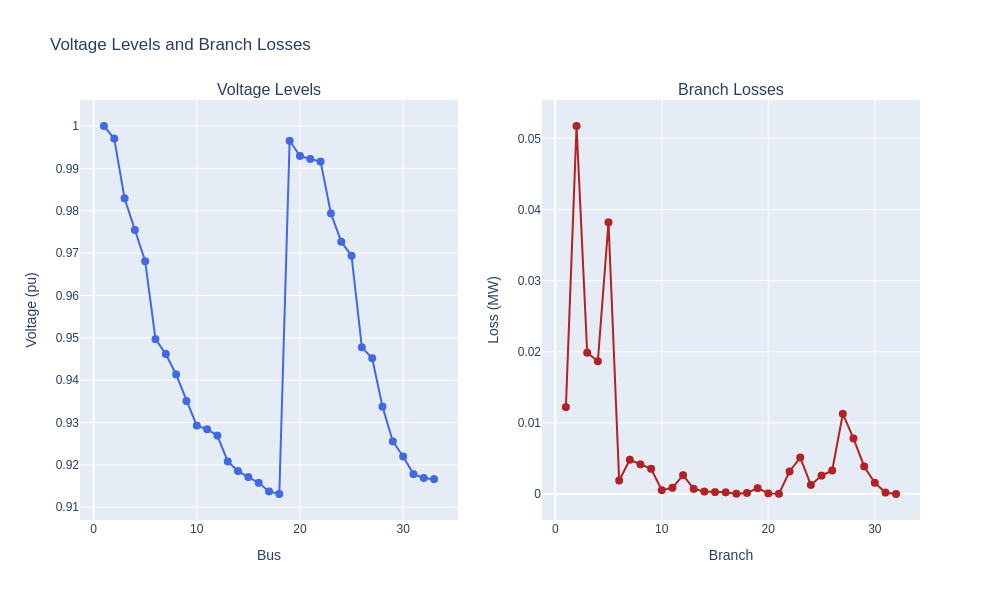

In [5]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import Image

# Define the data
bus_numbers = np.arange(1, len(hourlyvoltage1) + 1)
branch_numbers = np.arange(1, len(hourlybranchloss1) + 1)

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Voltage Levels", "Branch Losses"))

# Voltage plot
fig.add_trace(go.Scatter(
    x=bus_numbers, y=hourlyvoltage1, mode='lines+markers',
    line=dict(color='royalblue'),
    marker=dict(size=8, color='royalblue'),
    name="Voltage Levels"
), row=1, col=1)

# Branch losses plot
fig.add_trace(go.Scatter(
    x=branch_numbers, y=hourlybranchloss1, mode='lines+markers',
    line=dict(color='firebrick'),
    marker=dict(size=8, color='firebrick'),
    name="Branch Losses"
), row=1, col=2)

# Update layout
fig.update_layout(
    height=600, width=1000,
    title_text="Voltage Levels and Branch Losses",
    showlegend=False
)
fig.update_xaxes(title_text="Bus", row=1, col=1)
fig.update_yaxes(title_text="Voltage (pu)", row=1, col=1)
fig.update_xaxes(title_text="Branch", row=1, col=2)
fig.update_yaxes(title_text="Loss (MW)", row=1, col=2)
# fig.show()
fig.write_image("VLBL.png")
# Display saved image in notebook
Image("VLBL.png")

# Load Flow for 24-Hours

In [6]:
# Main Code for 24 hours
basekv = 12.66  # 11 kV
basemva = 100
base_impedance = (basekv) ** 2 / basemva
s = 1 / base_impedance
accuracy = 0.001
maxiter = 1000
x = 0.001
# Load levels for different times of the day (24 hours)
loadlevel = np.array([65, 60, 56, 57, 58, 58.5, 59, 62, 67, 69.5, 72, 79, 88, 93, 98, 100, 97, 93, 88, 85.5, 82, 73, 62, 58]) / 100
# Voltage and loss matrices for storage
hourlyvoltage = np.zeros((33, 24))  # 33 buses, 24 hours
hourlybranchloss = np.zeros((32, 24))
hourlyLoss = np.zeros(24)
# Loop over 24 hours
for kk in range(24):
    busdata = np.copy(original_busdata)
# adjust load data based on the loadlevel array
    busdata[:, 4] = loadlevel[kk] * original_busdata[:, 4]  # Active power demand
    busdata[:, 5] = loadlevel[kk] * original_busdata[:, 5]  # Reactive power demand
    Vm, delta, P, Q, Loss, QLoss, tech, branchloss =NRPF(busdata, linedata, basemva, accuracy, maxiter)
    hourlyLoss[kk] = Loss
    hourlyvoltage[:, kk] = Vm
    hourlybranchloss[:, kk] = branchloss

Power Flow Solution by Newton-Raphson Method
Maximum Power Mismatch = 0.0003255153061700734
No. of Iterations = 2

Bus  Voltage  Angle    ------Load------    ---Generation---   Injected
No.  Mag.     Degree     MW       Mvar       MW       Mvar       Mvar

    1   1.000    0.000     0.000     0.000     0.000     0.000    0.000
    2   0.998    0.009     0.065     0.039     0.000     0.000    0.000
    3   0.989    0.060     0.058     0.026     0.000     0.000    0.000
    4   0.984    0.101     0.078     0.052     0.000     0.000    0.000
    5   0.980    0.143     0.039     0.019     0.000     0.000    0.000
    6   0.968    0.083     0.039     0.013     0.000     0.000    0.000
    7   0.966   -0.059     0.130     0.065     0.000     0.000    0.000
    8   0.963   -0.037     0.130     0.065     0.000     0.000    0.000
    9   0.959   -0.083     0.039     0.013     0.000     0.000    0.000
   10   0.955   -0.121     0.039     0.013     0.000     0.000    0.000
   11   0.955   -0.117 

Load Flow Results

In [7]:
hourlyLoss[kk] = Loss
hourlyvoltage[:, kk] = Vm
hourlybranchloss[:, kk] = branchloss
# Print the Hourly Power Loss
# print("Hourly Power Loss:")
# print(hourlyLoss)
# # Print the Voltage Levels
# print("\nHourly Voltage Levels (per bus):")
# print(hourlyvoltage)
# # Print the Branch Losses
# print("\nHourly Branch Losses (per branch):")
# print(hourlybranchloss)


# Plot Hourly Loss (Total Loss)

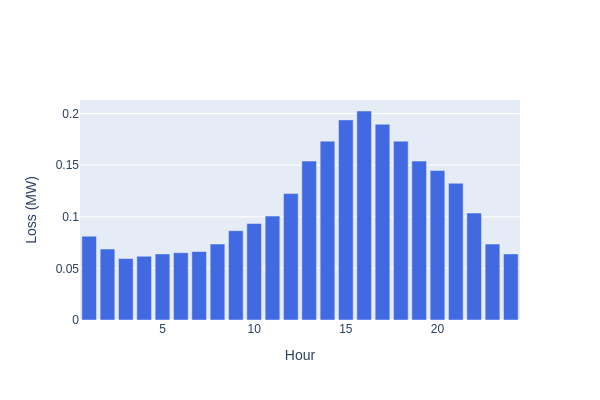

In [8]:
hours = np.arange(1, 25)
fig_loss = go.Figure(go.Bar(
    x=hours,
    y=hourlyLoss,
    marker=dict(color='royalblue'),
    name="Hourly Power Loss"
))
fig_loss.update_layout(
    xaxis_title="Hour",
    yaxis_title="Loss (MW)",
    height=400, width=600
)
# fig_loss.show()
fig_loss.write_image("HL.png")
Image("HL.png")

# Plot Bus Voltage Values for 24-Hours

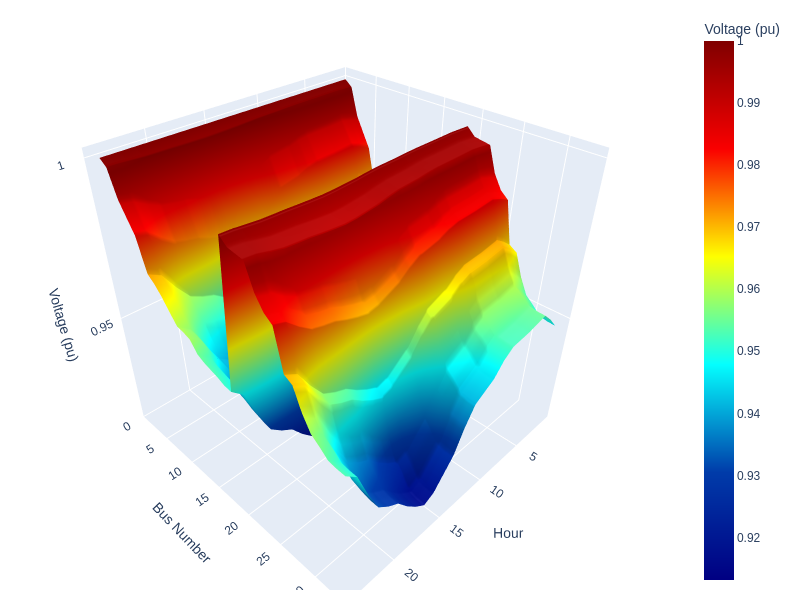

In [9]:
fig = go.Figure()
X, Y = np.meshgrid(np.arange(1, 25), np.arange(1, 34))
Z = hourlyvoltage
fig.add_trace(go.Surface(x=X, y=Y, z=Z, colorscale='jet', colorbar=dict(title='Voltage (pu)')))
fig.update_layout(
    scene=dict(
        xaxis_title='Hour',
        yaxis_title='Bus Number',
        zaxis_title='Voltage (pu)',
    ),
    margin=dict(l=10, r=10, b=10, t=10),
    width=800,
    height=600
)
# fig.show()
fig.write_image("VL3.png")
Image("VL3.png")

# Plot Branch Loss Values for 24-Hours

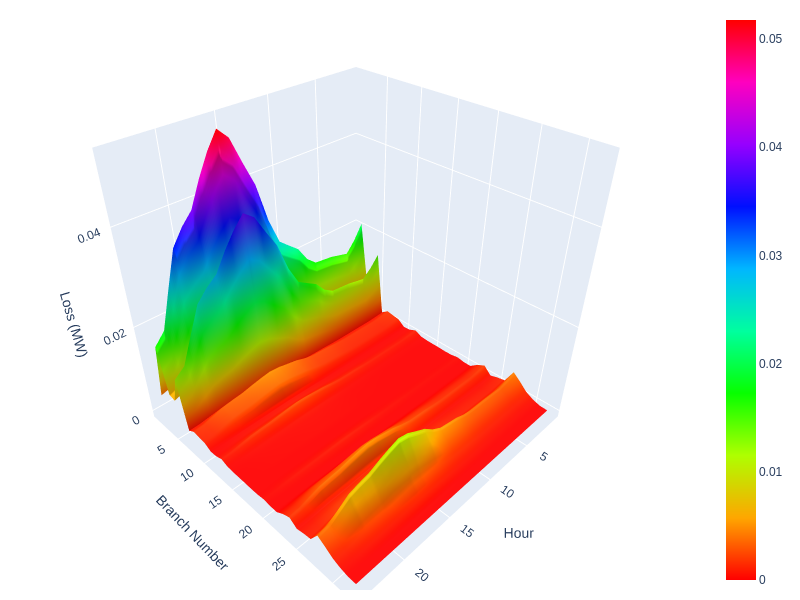

In [10]:
X = np.arange(1, 25)
Y = np.arange(1, 33)
Z = hourlybranchloss
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='hsv')])
fig.update_layout(
    scene=dict(
        xaxis_title='Hour',
        yaxis_title='Branch Number',
        zaxis_title='Loss (MW)',
    ),
    margin=dict(l=10, r=10, b=10, t=10),
    width=800,
    height=600
)
# fig.show()
fig.write_image("L3.png")
Image("L3.png")